In [380]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler


In [381]:
# Setting random seed for reproducibility
torch.manual_seed(140)
np.random.seed(140)
random.seed(140)

In [382]:
# Simulate data 
x_values = torch.tensor([1, 2, 3], dtype=torch.float32).view(-1, 1, 1)
y_values = torch.tensor([10, 20, 30], dtype=torch.float32).view(-1, 1, 1)

# Create a scaler
sc_x = RobustScaler()
sc_y = RobustScaler()

# Shape the data from 3D to 2D
x_values_2D = x_values.squeeze(-1).numpy()
y_values_2D = y_values.squeeze(-1).numpy()

# Fit the scaler and transform the data
x_scaled = sc_x.fit_transform(x_values_2D)
y_scaled = sc_y.fit_transform(y_values_2D)

# Reshape the data back to 3D and convert to tensor
x_scaled = torch.tensor(x_scaled).unsqueeze(-1)
y_scaled = torch.tensor(y_scaled).unsqueeze(-1)

class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

dataset = CustomDataset(x_scaled, y_scaled)

train_loader = DataLoader(dataset=dataset, batch_size=3, shuffle=False)

In [383]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :]) # Extract only the last timestep's output for prediction
        return x

    def train_model(self, train_loader, num_epochs=50, learning_rate=0.05):
        # Initialize the optimizer and loss function
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss() # Mean Squared Error Loss

        # Train the model
        for epoch in range(num_epochs):
            self.train() # Set the model to training mode
            for x, y in train_loader:
                output = self(x) # Forward pass
                optimizer.zero_grad() # Clear the gradients
                loss = loss_fn(output, y.view(-1, 1)) # Compute the loss
                loss.backward() # Backward pass
                optimizer.step() # Update the weights
    
            if epoch % 5 == 0: # Print the loss every 5 epochs
                print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
        
        return self

In [384]:
model = LSTM(input_size=1, hidden_size=10, num_layers=1, output_size=1) # Train the model

model = model.train_model(train_loader=train_loader ,num_epochs=50, learning_rate=0.01)

Epoch [0/50], Loss: 0.698601245880127
Epoch [5/50], Loss: 0.6125347018241882
Epoch [10/50], Loss: 0.5236238241195679
Epoch [15/50], Loss: 0.42602625489234924
Epoch [20/50], Loss: 0.307224303483963
Epoch [25/50], Loss: 0.1728971004486084


Epoch [30/50], Loss: 0.06459332257509232
Epoch [35/50], Loss: 0.006195520982146263
Epoch [40/50], Loss: 0.006384280975908041
Epoch [45/50], Loss: 0.018704555928707123


X Value	Actual Y	Predicted Y
1.0	10	8.5011568069458
2.0	20	19.716440200805664
3.0	30	31.163541793823242
4.0	40	37.508575439453125


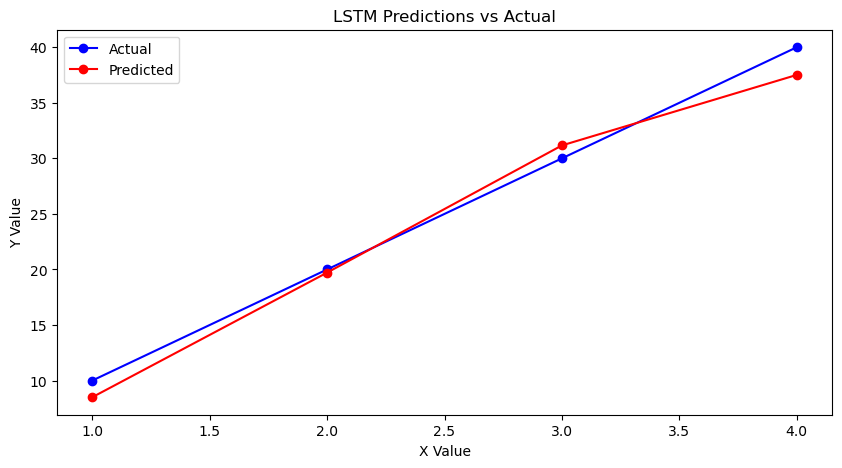

In [385]:
# Your manually specified actual_y values
actual_y = np.array([10, 20, 30, 40])  # Example actual y values for x values [1, 2, 3, 4]

# Assuming `sc_x` and `sc_y` are already fitted to your training data
# Prepare multiple x values for prediction
x_to_predict = torch.tensor([1, 2, 3, 4], dtype=torch.float32).view(-1, 1, 1)  # Example x values

x_to_predict_2D = x_to_predict.squeeze(-1).numpy()  # Convert to 2D for scaling
x_to_predict_scaled = sc_x.transform(x_to_predict_2D)  # Scale x values
x_to_predict_scaled_tensor = torch.tensor(x_to_predict_scaled, dtype=torch.float32).view(-1, 1, 1)  # Convert back to tensor

model = model.eval()    # Set the model to evaluation mode
predictions_scaled = [] # Store the scaled predictions
with torch.no_grad():  # Disable gradient tracking
    for x_val in x_to_predict_scaled_tensor: # Iterate over each x value
        prediction_scaled = model(x_val.unsqueeze(0))  # Add batch dimension
        predictions_scaled.append(prediction_scaled) # Store the scaled prediction

# Convert predictions to a numpy array for inverse transform
predictions_scaled_np = torch.cat(predictions_scaled, dim=0).numpy()
predictions = sc_y.inverse_transform(predictions_scaled_np.reshape(-1, 1))  # Inverse transform predictions

# Print Actual vs Predicted
predicted_y = predictions.flatten()

# Print the actual and predicted values
print("X Value\tActual Y\tPredicted Y")
for i, x_val in enumerate(x_to_predict.numpy().flatten()):
    print(f"{x_val}\t{actual_y[i]}\t{predicted_y[i]}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_to_predict.numpy().flatten(), actual_y, 'bo-', label='Actual')
plt.plot(x_to_predict.numpy().flatten(), predicted_y, 'ro-', label='Predicted')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.legend()
plt.show()